# Import Packages and Dataset

## Packages

In [1]:
!pip install transformers

In [0]:
%tensorflow_version 2.x

In [3]:
import torch
import transformers as tfm # pytorch transformers
from sklearn.linear_model import LogisticRegression

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import InputLayer

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,hamming_loss

from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import pickle

from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset

In [4]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_train_full_preprocessed.csv'

data_train = pd.read_csv(train_path,sep=";")

In [6]:
data_train.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,- kdg will be kind enough to show you how to l...,0,1,0,0,0,0,0,0,0,0,0,0,kadang kind enough show look kelas teman kampu...
1,Ternyata komunis juga bisa nangis',0,0,0,0,0,0,0,0,0,0,0,0,nyata komunis menang
2,USER USER Kenapa harus bom ya? Kek yg benar nu...,0,0,0,0,0,0,0,0,0,0,0,0,user user bom embel bom takut orang orang korban
3,USER Sumpaaah kaya kalo abis IAA dilanjut olim...,0,0,0,0,0,0,0,0,0,0,0,0,user sumpah kaya habis iya olimpiade pagelaran...
4,RT USER USER USER USER USER fungsi media sosia...,1,0,1,0,0,0,0,0,1,1,0,0,user user user user user fungsi medium sosial ...


In [0]:
test_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_test_full_preprocessed.csv'

data_test = pd.read_csv(test_path,sep=";")

In [8]:
data_test.head()

,Index,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,1,GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO ...,1,1,1,0,0,0,0,0,1,1,0,0,ganteng berengsek think nothing remember
1,2,Sakit jiwa kali yah..,0,0,0,0,0,0,0,0,0,0,0,0,sakit jiwa kali
2,3,"Does insulting one for being ""Cina"", ""Kafir"", ...",0,1,0,0,0,0,0,0,0,0,0,0,insult one cina kafir make good muslim
3,4,USER USER Karena partaimu pdip itu bajingan',1,1,0,1,0,0,0,0,1,0,1,0,user user partai partai demokrasi indonesia ju...
4,5,USER USER Jgn salah itu janji jokowi yg di tun...,1,1,1,0,0,0,0,0,1,1,0,0,user user salah janji jokowi tuntut paham kece...


In [0]:
val_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_val_full_preprocessed.csv'

data_val = pd.read_csv(val_path,sep=";")

In [10]:
data_val.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,So much berengsek people in the world,1,1,0,1,0,0,0,0,1,0,1,0,much berengsek people world
1,"So, how can I get my REKBER?? rekening berengsek.",0,1,0,0,0,0,0,0,0,0,0,0,get rekening berengsek rekening berengsek
2,RT USER: dasar bajingan!\xf0\x9f\x98\xa0 URL,0,1,0,0,0,0,0,0,0,0,0,0,user dasar bajing
3,USER Krn cebong tdk akn mengakui pria lajang y...,1,1,0,1,0,0,0,0,1,0,1,0,user kecebong pria lajang lulu sastra profesor...
4,"RT USER: ga ada urusannya, monyet. gua broken ...",1,1,1,0,0,0,0,0,1,1,0,0,user urus monyet break home teman teman kaya r...


# Features Target Split

In [0]:
X_train = data_train['Tweet_Parsed']
y_train = data_train.drop(['Tweet','Tweet_Parsed'],axis=1).values

X_val = data_val['Tweet_Parsed']
y_val = data_val.drop(['Tweet','Tweet_Parsed'],axis=1).values


X_test = data_test['Tweet_Parsed']
y_test = data_test.drop(['Tweet','Tweet_Parsed','Index'],axis=1).values

# DistilBert Model

In [0]:
model_class, tokenizer_class, pretrained_weights = (tfm.DistilBertModel, tfm.DistilBertTokenizer, 'distilbert-base-multilingual-cased')

## Load Tokenizer and Model

In [0]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

## Tokenize Train Set, Validation Set, and Test Set

In [0]:
train_sequences = X_train.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [0]:
validation_sequences = X_val.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [0]:
test_sequences = X_test.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [0]:
train_padded = sequence.pad_sequences(train_sequences, maxlen=100, padding="post", truncating="post")

In [0]:
validation_padded = sequence.pad_sequences(validation_sequences, maxlen=100, padding="post", truncating="post")

In [0]:
test_padded = sequence.pad_sequences(test_sequences, maxlen=100, padding="post", truncating="post")

## Change Padded to Tensor and Run Model (Forward Pass)

In [0]:
train_ids = torch.tensor(np.array(train_padded)).to(torch.int64)
train_features = []
batch_size = 200
for batch in tqdm(range(0,len(train_ids),batch_size)):
  with torch.no_grad():
    train_last_hidden_states = model(train_ids[batch:batch+batch_size])
    train_features.append(train_last_hidden_states[0])
# train_features = train_features.numpy()

100%|██████████| 67/67 [14:12<00:00, 12.72s/it]


In [0]:
train_features = np.concatenate(train_features)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_train_full_3d.pkl', 'wb') as f:
  pickle.dump(train_features, f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_train_full_3d.pkl', 'wb') as f:
  pickle.dump(y_train, f)

In [0]:
validation_ids = torch.tensor(np.array(validation_padded)).to(torch.int64)
validation_features = []
batch_size = 200
for batch in tqdm(range(0,len(validation_ids),batch_size)):
  with torch.no_grad():
    validation_last_hidden_states = model(validation_ids[batch:batch+batch_size])
    validation_features.append(validation_last_hidden_states[0])

100%|██████████| 8/8 [01:38<00:00, 12.30s/it]


In [0]:
validation_features = np.concatenate(validation_features)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_validation_full_3d.pkl', 'wb') as f:
  pickle.dump(validation_features, f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_validation_full_3d.pkl', 'wb') as f:
  pickle.dump(y_val, f)

In [0]:
test_ids = torch.tensor(np.array(test_padded)).to(torch.int64)
test_features = []
batch_size = 200
for batch in tqdm(range(0,len(test_ids),batch_size)):
  with torch.no_grad():
    test_last_hidden_states = model(test_ids[batch:batch+batch_size])
    test_features.append(test_last_hidden_states[0])

100%|██████████| 19/19 [03:52<00:00, 12.24s/it]


In [0]:
test_features = np.concatenate(test_features)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_test_full_3d.pkl', 'wb') as f:
  pickle.dump(test_features, f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_test_full_3d.pkl', 'wb') as f:
  pickle.dump(y_test, f)

In [0]:
while 1:
  print("",end="")

KeyboardInterrupt: ignored

In [0]:
train_features.shape

(13244, 100, 768)

In [0]:
validation_features.shape

(1472, 100, 768)

In [0]:
test_features.shape

(3680, 100, 768)

# Classification

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_train_full_3d.pkl', 'rb') as f:
  train_features = pickle.load(f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_train_full_3d.pkl', 'rb') as f:
  y_train = pickle.load(f)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_validation_full_3d.pkl', 'rb') as f:
  validation_features = pickle.load(f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_validation_full_3d.pkl', 'rb') as f:
  y_val = pickle.load(f)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_test_full_3d.pkl', 'rb') as f:
  test_features = pickle.load(f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_test_full_3d.pkl', 'rb') as f:
  y_test = pickle.load(f)

## Define Model

In [17]:
model = Sequential()
# Configuring the parameters
model.add(InputLayer((100,768)))
model.add(Conv1D(128,5, activation="relu"))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation="relu"))
model.add(Dense(12, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 96, 128)           491648    
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                780       
Total params: 500,684
Trainable params: 500,684
Non-trainable params: 0
_________________________________________________________________


## Training Model with Adam Optimizer

In [18]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(train_features, y_train, 
                    validation_data=(validation_features, y_val),
                    epochs=80, batch_size=32, 
                    verbose=2)

Epoch 1/80
414/414 - 3s - loss: 0.3725 - accuracy: 0.4743 - val_loss: 0.3660 - val_accuracy: 0.6012
Epoch 2/80
414/414 - 3s - loss: 0.3525 - accuracy: 0.5249 - val_loss: 0.3561 - val_accuracy: 0.6250
Epoch 3/80
414/414 - 3s - loss: 0.3417 - accuracy: 0.5351 - val_loss: 0.3447 - val_accuracy: 0.4361
Epoch 4/80
414/414 - 3s - loss: 0.3366 - accuracy: 0.5351 - val_loss: 0.3473 - val_accuracy: 0.4266
Epoch 5/80
414/414 - 3s - loss: 0.3334 - accuracy: 0.5390 - val_loss: 0.3356 - val_accuracy: 0.5306
Epoch 6/80
414/414 - 3s - loss: 0.3274 - accuracy: 0.5344 - val_loss: 0.3328 - val_accuracy: 0.6209
Epoch 7/80
414/414 - 3s - loss: 0.3249 - accuracy: 0.5325 - val_loss: 0.3411 - val_accuracy: 0.4599
Epoch 8/80
414/414 - 3s - loss: 0.3204 - accuracy: 0.5299 - val_loss: 0.3269 - val_accuracy: 0.4694
Epoch 9/80
414/414 - 3s - loss: 0.3180 - accuracy: 0.5211 - val_loss: 0.3312 - val_accuracy: 0.5632
Epoch 10/80
414/414 - 3s - loss: 0.3137 - accuracy: 0.5235 - val_loss: 0.3302 - val_accuracy: 0.4776

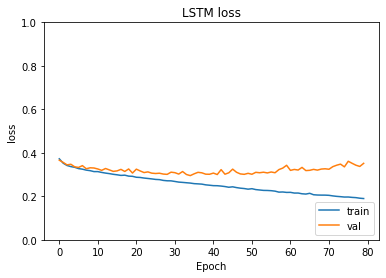

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Predict and Result

In [0]:
predict = model.predict(test_features)
predict_train = model.predict(train_features)
predict_val = model.predict(validation_features)
thresholds=0.5

In [0]:
def labelSetAccuracy(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
#         print('\nset_true: {0}'.format(set_true))
#         print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [23]:
pred_test = predict.copy()
pred_test[pred_test>=0.5] = 1
pred_test[pred_test<0.5] = 0
acc = accuracy_score(y_test,pred_test)
haml_loss = hamming_loss(y_test,pred_test)
label_acc = labelSetAccuracy(y_test,pred_test)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")

threshold =  0.5
exact accuracy =  0.50625
hamming loss =  0.12162590579710145
label based accuracy =  0.6127658083160802


In [24]:
pred_train = predict_train.copy()
pred_train[pred_train>=0.5] = 1
pred_train[pred_train<0.5] = 0
acc = accuracy_score(y_train,pred_train)
haml_loss = hamming_loss(y_train,pred_train)
label_acc = labelSetAccuracy(y_train,pred_train)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")


threshold =  0.5
exact accuracy =  0.627302929628511
hamming loss =  0.07779623477297896
label based accuracy =  0.7414902465566917


In [25]:
pred_val = predict_val.copy()
pred_val[pred_val>=0.5] = 1
pred_val[pred_val<0.5] = 0
acc = accuracy_score(y_val,pred_val)
haml_loss = hamming_loss(y_val,pred_val)
label_acc = labelSetAccuracy(y_val,pred_val)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")


threshold =  0.5
exact accuracy =  0.5
hamming loss =  0.12511322463768115
label based accuracy =  0.6053846402691512


## Save Model

In [0]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Model/modeldistilBERT_full.h5')

In [0]:
from tensorflow.keras.models import load_model
model = load_model('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Model/modeldistilBERT_full.h5')

# Analysis Predict

In [0]:
target = data_train.columns[1:-1]

## Data Validation Predict Analysis

In [0]:
data_val = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).reset_index(drop=True).join(pd.DataFrame(y_val,columns=target)).reset_index(drop=True)

In [29]:
data_val.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,much berengsek people world,1,1,0,1,0,0,0,0,1,0,1,0
1,get rekening berengsek rekening berengsek,0,1,0,0,0,0,0,0,0,0,0,0
2,user dasar bajing,0,1,0,0,0,0,0,0,0,0,0,0
3,user kecebong pria lajang lulu sastra profesor...,1,1,0,1,0,0,0,0,1,0,1,0
4,user urus monyet break home teman teman kaya r...,1,1,1,0,0,0,0,0,1,1,0,0


In [0]:
data_val_predict = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).reset_index(drop=True).join(pd.DataFrame(data=pred_val, columns=target))

In [31]:
data_val_predict.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,much berengsek people world,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,get rekening berengsek rekening berengsek,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,user dasar bajing,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,user kecebong pria lajang lulu sastra profesor...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,user urus monyet break home teman teman kaya r...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Check Number of Label on Predict Data

In [0]:
label_size0_val = []
label_size1_val = []

for i in data_val.columns[1:]:
    label_size0_val.append(len(data_val[data_val[i]==0]))
    label_size1_val.append(len(data_val[data_val[i]==1]))

label_size0_val_predict = []
label_size1_val_predict = []

for i in data_val_predict.columns[1:]:
    label_size0_val_predict.append(len(data_val_predict[data_val_predict[i]==0]))
    label_size1_val_predict.append(len(data_val_predict[data_val_predict[i]==1]))

In [0]:
dat_anls_val = pd.DataFrame({
    'label' : data_val.columns[1:],
    'stats' : ["negative" for i in range(len(data_val.columns[1:]))],
    'jumlah' : label_size0_val
}).append(
    pd.DataFrame({
        'label' : data_val.columns[1:],
        'stats' : ["positive" for i in range(len(data_val.columns[1:]))],
        'jumlah' : label_size1_val
    })
)

# dat_anls_val = dat_anls_val.set_index(['label'], drop=True)

dat_anls_val_predict = pd.DataFrame({
    'label' : data_val_predict.columns[1:],
    'stats' : ["negative" for i in range(len(data_val_predict.columns[1:]))],
    'jumlah' : label_size0_val_predict
}).append(
    pd.DataFrame({
        'label' : data_val_predict.columns[1:],
        'stats' : ["positive" for i in range(len(data_val_predict.columns[1:]))],
        'jumlah' : label_size1_val_predict
    })
)

# dat_anls_val_predict = dat_anls_val_predict.set_index(['label'], drop=True)

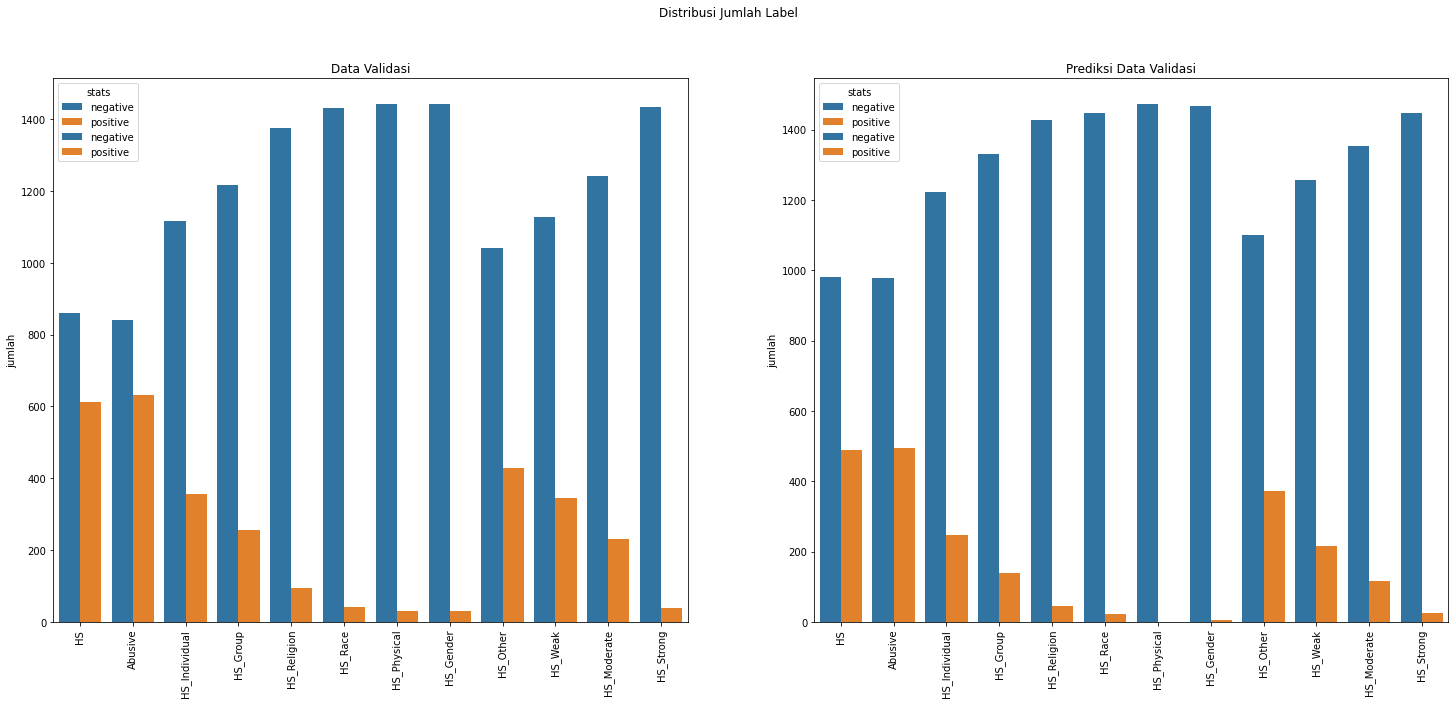

In [34]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).get_xticklabels(),rotation=90)
plt.title("Data Validasi")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Validasi")
plt.xlabel('')

plt.show()

In [35]:
pd.DataFrame({
    "label" : data_val.columns[1:],
    "negative (true)" : dat_anls_val[dat_anls_val['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_val[dat_anls_val['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,859,613,982,490
1,Abusive,840,632,977,495
2,HS_Individual,1115,357,1224,248
3,HS_Group,1216,256,1332,140
4,HS_Religion,1376,96,1427,45
5,HS_Race,1431,41,1448,24
6,HS_Physical,1441,31,1472,0
7,HS_Gender,1441,31,1467,5
8,HS_Other,1042,430,1100,372
9,HS_Weak,1128,344,1256,216


### OOV Check

In [0]:
def generate_ngrams(s):
    
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.str.split(" ") if token != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = np.concatenate(tokens)
    return ngrams

def oov(fitur,token):
    outOfVocab = []
    for i in token:
        if i not in fitur:
            outOfVocab.append(i)
    return outOfVocab

def oov_count(oovList):
    oovCount = {}
    for i in oovList:
        if i in oovCount.keys():
            oovCount[i] = oovCount[i]+1
        else:
            oovCount[i] = 1
    return oovCount

In [0]:
join_data_val = data_val.join(data_val_predict.drop(['Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_val = join_data_val[(join_data_val["HS"]!=join_data_val["HS_predict"]) | (join_data_val["Abusive"] != join_data_val["Abusive_predict"]) | (join_data_val["HS_Individual"] != join_data_val["HS_Individual_predict"]) | (join_data_val["HS_Group"] != join_data_val["HS_Group_predict"]) | (join_data_val["HS_Religion"] != join_data_val["HS_Religion_predict"]) | (join_data_val["HS_Race"] != join_data_val["HS_Race"]) | (join_data_val["HS_Physical"] != join_data_val["HS_Physical_predict"]) | (join_data_val["HS_Gender"] != join_data_val["HS_Gender_predict"]) | (join_data_val["HS_Other"] != join_data_val["HS_Other_predict"]) | (join_data_val["HS_Weak_predict"] != join_data_val["HS_Weak_predict"]) | (join_data_val["HS_Moderate_predict"] != join_data_val["HS_Moderate_predict"]) | (join_data_val["HS_Strong_predict"] != join_data_val["HS_Strong_predict"])]

In [0]:
vocab = tokenizer.ids_to_tokens.values()

In [40]:
tokenizer.ids_to_tokens.values()

odict_values(['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[unused31]', '[unused32]', '[unused33]', '[unused34]', '[unused35]', '[unused36]', '[unused37]', '[unused38]', '[unused39]', '[unused40]', '[unused41]', '[unused42]', '[unused43]', '[unused44]', '[unused45]', '[unused46]', '[unused47]', '[unused48]', '[unused49]', '[unused50]', '[unused51]', '[unused52]', '[unused53]', '[unused54]', '[unused55]', '[unused56]', '[unused57]', '[unused58]', '[unused59]', '[unused60]', '[unused61]', '[unused62]', '[unused63]', '[unused64]', '[unused65]', '[unused66]', '[unused67]', '[unused68]', '[unused69]', '[unused70]', '[unus

In [0]:
oov_val = oov(vocab, generate_ngrams(miss_exact_tweet_val['Tweet_Parsed']))
oov_val_count = oov_count(oov_val)

In [42]:
oov_val_count

{'berengsek': 14,
 'bajing': 11,
 'urus': 5,
 'monyet': 11,
 'celeng': 2,
 'synna': 1,
 'emosi': 1,
 'mancing': 1,
 'sinting': 2,
 'minum': 4,
 'obat': 2,
 'angkat': 1,
 'banyuwangi': 1,
 'kunci': 1,
 'bec': 1,
 'bacot': 12,
 'bahas': 3,
 'rusak': 4,
 'revitalisasi': 1,
 'didik': 3,
 'bodoh': 12,
 'keleees': 1,
 'lihat': 24,
 'ganti': 26,
 'ogah': 1,
 'ajar': 5,
 'maksud': 3,
 'kucing': 2,
 'joke': 4,
 'laugh': 2,
 'anjir': 6,
 'sangka': 1,
 'kemarin': 7,
 'sarap': 3,
 'melulu': 2,
 'bangsat': 34,
 'expect': 3,
 'fuck': 49,
 'munafik': 19,
 'maaf': 5,
 'cant': 2,
 'nice': 4,
 'hate': 4,
 'deserve': 2,
 'jembut': 3,
 'tuduh': 2,
 'komunis': 30,
 'indonesia': 121,
 'jokowi': 52,
 'kampanye': 5,
 'useruser': 1,
 'memframing': 1,
 'olah': 3,
 'suci': 6,
 'rocky': 2,
 'kecebong': 36,
 'leyeh': 2,
 'tonton': 8,
 'busuk': 4,
 'butterbean': 1,
 'duit': 11,
 'cong': 2,
 'rampok': 2,
 'jual': 3,
 'otak': 14,
 'banget': 22,
 'gaul': 1,
 'lingkung': 1,
 'tionghoa': 4,
 'pakistan': 2,
 'saudi': 5,


In [43]:
print("number of OOV words : ", len(oov_val))
print("number of unique OOV words : ", len(oov_val_count))

number of OOV words :  4207
number of unique OOV words :  1699


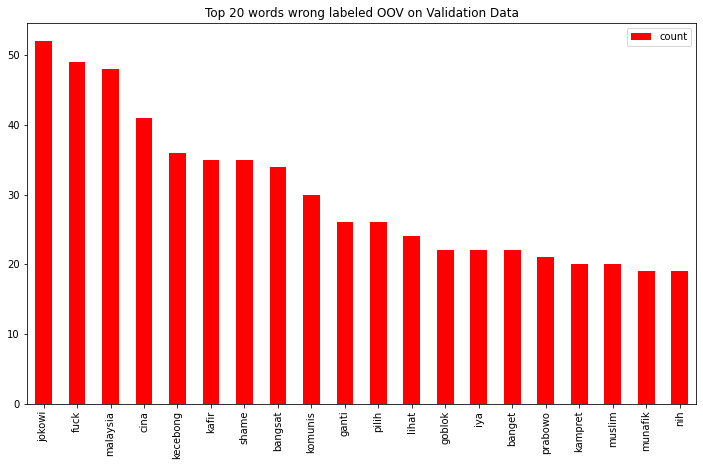

In [44]:
df_oov_val = pd.DataFrame(oov_val_count.items(),columns=["Tweet","count"])
df_oov_val.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

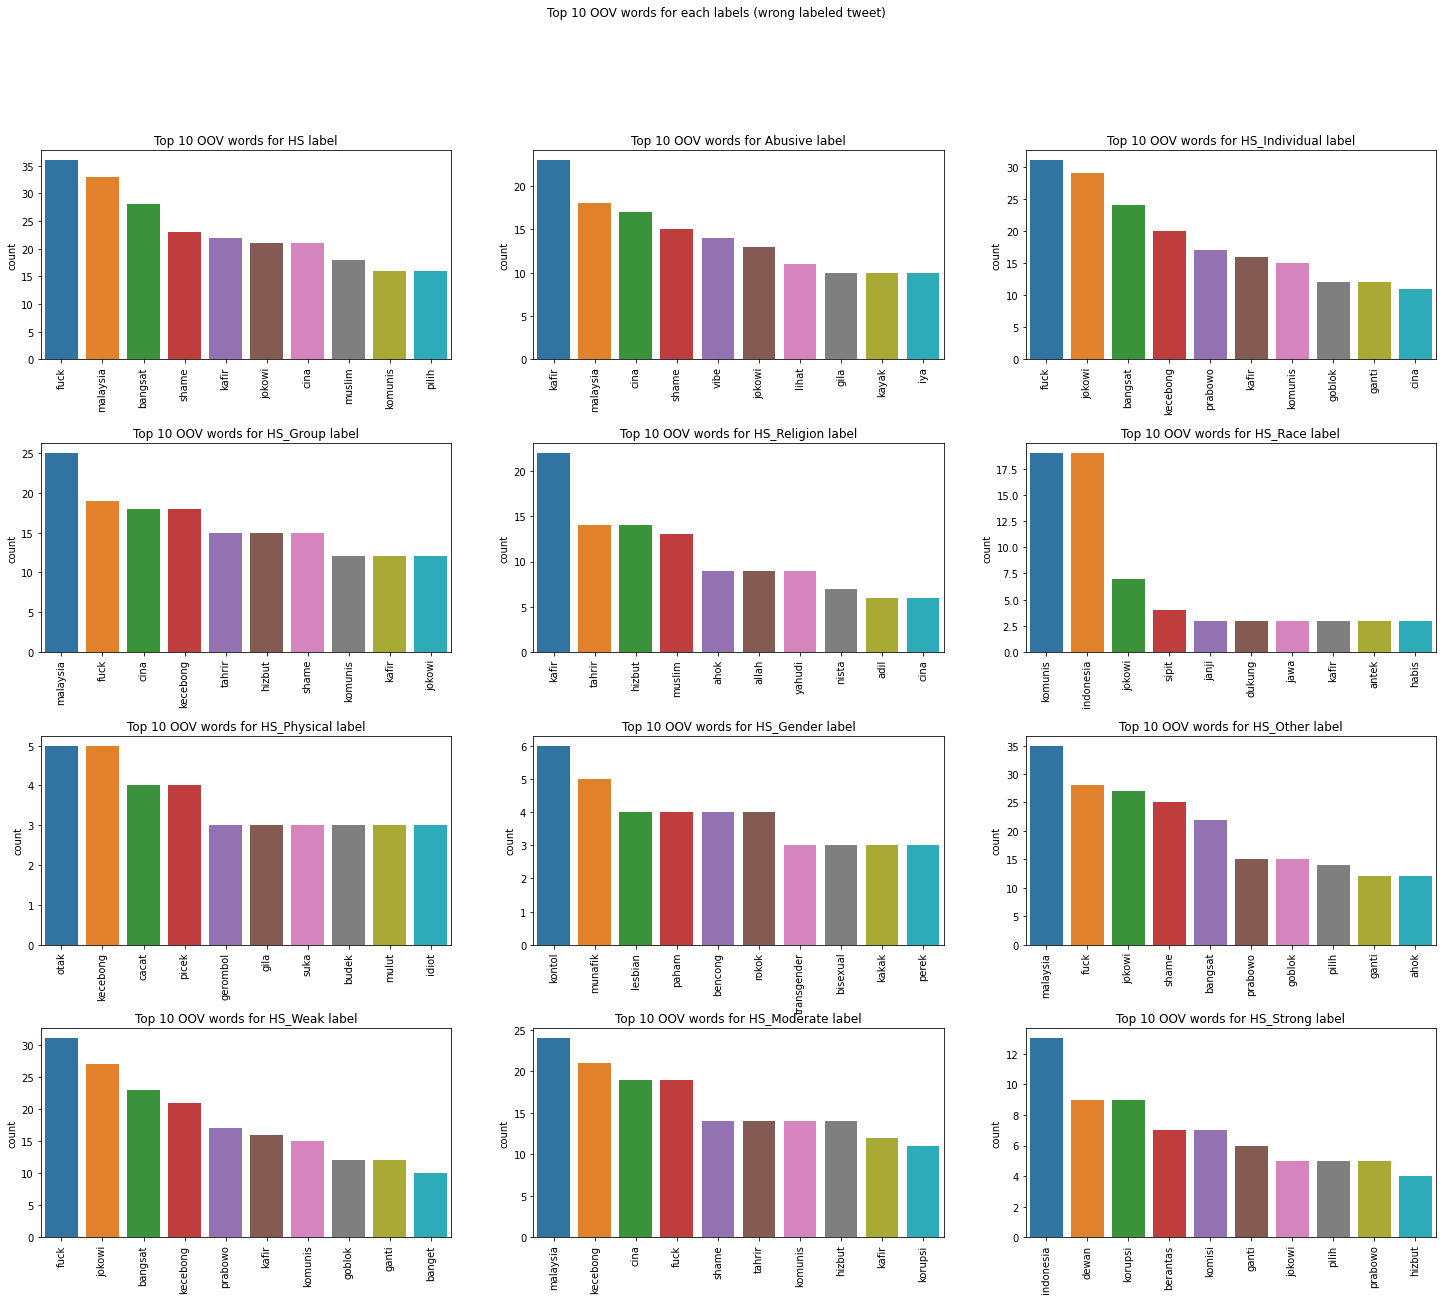

In [45]:

plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_val[join_data_val[target[i]]!=join_data_val[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vocab, wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

### Tweet Check

In [46]:
miss_exact_tweet_val['Tweet_Parsed'].values.tolist()

['much berengsek people world',
 'user dasar bajing',
 'user urus monyet break home teman teman kaya raya h',
 'user tai join tag close agency basic',
 'user user celeng synna emosi mancing',
 'sinting minum obat',
 'angkat tradisi budaya rakyat banyuwangi kunci sukses bec',
 'user user bacot',
 'bahas islam rusak nilai user kuat karakter revitalisasi didik nilai',
 'user bodoh pengaruh keleees lihat poll google presiden ganti ganti presiden ogah ganti presiden',
 'ajar point maksud anjing predator kucing prey think get back school joke around laugh',
 'user anjir sangka kemarin sarap orang rest melulu gara gara gagal move gagal move mantan',
 'know bangsat need expect anything fuck loser',
 'munafik maaf cant main nice people hate',
 'deserve date user jembut',
 'user tuduh user partai komunis indonesia jokowi anti islam rakyat percaya kampanye contoh useruser user',
 'user user memframing olah kitab suci milik umat islam umat demo salah rocky kecebong leyeh leyeh tonton demo televisi

In [47]:
miss_exact_tweet_val.iloc[:,1:-12].columns

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')

In [48]:
miss_exact_tweet_val.iloc[:,-12:].values.tolist()

[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

## Data Test Predict Analysis

In [0]:
data_test_predict = pd.DataFrame(data=data_test['Tweet'],columns=['Tweet']).reset_index(drop=True).join(pd.DataFrame(data=pred_test, columns=target)).join(pd.DataFrame(data=data_test['Tweet_Parsed'],columns=['Tweet_Parsed']).reset_index(drop=True))

In [50]:
data_test_predict.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO ...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ganteng berengsek think nothing remember
1,Sakit jiwa kali yah..,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sakit jiwa kali
2,"Does insulting one for being ""Cina"", ""Kafir"", ...",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,insult one cina kafir make good muslim
3,USER USER Karena partaimu pdip itu bajingan',1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,user user partai partai demokrasi indonesia ju...
4,USER USER Jgn salah itu janji jokowi yg di tun...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,user user salah janji jokowi tuntut paham kece...


### Check Number of Label on Predict Data

In [0]:
label_size0_test = []
label_size1_test = []

for i in data_test.columns[2:-1]:
    label_size0_test.append(len(data_test[data_test[i]==0]))
    label_size1_test.append(len(data_test[data_test[i]==1]))

label_size0_test_predict = []
label_size1_test_predict = []

for i in data_test_predict.columns[1:-1]:
    label_size0_test_predict.append(len(data_test_predict[data_test_predict[i]==0]))
    label_size1_test_predict.append(len(data_test_predict[data_test_predict[i]==1]))

In [0]:
dat_anls_test = pd.DataFrame({
    'label' : data_test.columns[2:-1],
    'stats' : ["negative" for i in range(len(data_test.columns[2:-1]))],
    'jumlah' : label_size0_test
}).append(
    pd.DataFrame({
        'label' : data_test.columns[2:-1],
        'stats' : ["positive" for i in range(len(data_test.columns[2:-1]))],
        'jumlah' : label_size1_test
    })
)

# dat_anls_test = dat_anls_test.set_index(['label'], drop=True)

dat_anls_test_predict = pd.DataFrame({
    'label' : data_test_predict.columns[1:-1],
    'stats' : ["negative" for i in range(len(data_test_predict.columns[1:-1]))],
    'jumlah' : label_size0_test_predict
}).append(
    pd.DataFrame({
        'label' : data_test_predict.columns[1:-1],
        'stats' : ["positive" for i in range(len(data_test_predict.columns[1:-1]))],
        'jumlah' : label_size1_test_predict
    })
)

# dat_anls_test_predict = dat_anls_test_predict.set_index(['label'], drop=True)

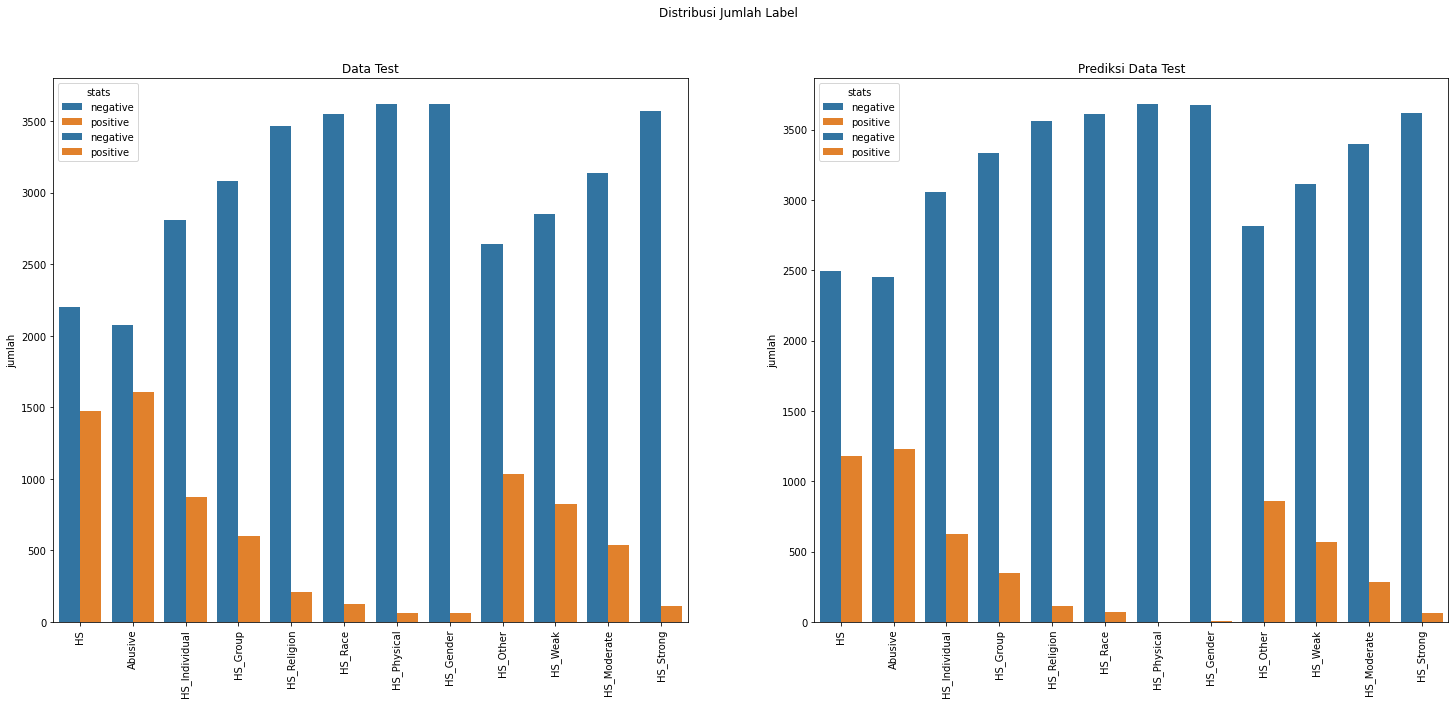

In [53]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).get_xticklabels(),rotation=90)
plt.title("Data Test")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Test")
plt.xlabel('')

plt.show()

In [54]:
pd.DataFrame({
    "label" : data_test.columns[2:-1],
    "negative (true)" : dat_anls_test[dat_anls_test['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_test[dat_anls_test['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,2204,1476,2497,1183
1,Abusive,2075,1605,2451,1229
2,HS_Individual,2806,874,3055,625
3,HS_Group,3078,602,3330,350
4,HS_Religion,3467,213,3564,116
5,HS_Race,3551,129,3610,70
6,HS_Physical,3617,63,3679,1
7,HS_Gender,3616,64,3674,6
8,HS_Other,2643,1037,2817,863
9,HS_Weak,2854,826,3110,570


### OOV Check

In [0]:
join_data_test = data_test.join(data_test_predict.drop(['Tweet','Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_test = join_data_test[(join_data_test["HS"]!=join_data_test["HS_predict"]) | (join_data_test["Abusive"] != join_data_test["Abusive_predict"]) | (join_data_test["HS_Individual"] != join_data_test["HS_Individual_predict"]) | (join_data_test["HS_Group"] != join_data_test["HS_Group_predict"]) | (join_data_test["HS_Religion"] != join_data_test["HS_Religion_predict"]) | (join_data_test["HS_Race"] != join_data_test["HS_Race_predict"]) | (join_data_test["HS_Physical"] != join_data_test["HS_Physical_predict"]) | (join_data_test["HS_Gender"] != join_data_test["HS_Gender_predict"]) | (join_data_test["HS_Other"] != join_data_test["HS_Other_predict"]) | (join_data_test["HS_Weak"] != join_data_test["HS_Weak_predict"]) | (join_data_test["HS_Moderate"] != join_data_test["HS_Moderate_predict"]) | (join_data_test["HS_Strong"] != join_data_test["HS_Strong_predict"])]

In [0]:
oov_test = oov(vocab, generate_ngrams(miss_exact_tweet_test['Tweet_Parsed']))
oov_test_count = oov_count(oov_test)

In [58]:
oov_test_count

{'ganteng': 5,
 'berengsek': 37,
 'demokrasi': 6,
 'indonesia': 294,
 'juang': 10,
 'bajing': 29,
 'ajar': 24,
 'garong': 3,
 'kafir': 84,
 'pecun': 10,
 'hobi': 2,
 'zina': 1,
 'jilid': 6,
 'cingkrang': 3,
 'malaysia': 130,
 'laku': 16,
 'syariat': 6,
 'judi': 1,
 'syarat': 1,
 'hamdalah': 1,
 'fitur': 1,
 'keparat': 8,
 'yue': 1,
 'excuse': 2,
 'kiki': 1,
 'charlotte': 1,
 'ronan': 1,
 'iya': 62,
 'jablay': 8,
 'lemah': 9,
 'gerindra': 4,
 'prabowo': 119,
 'elektabilitasnya': 1,
 'congor': 12,
 'fadli': 6,
 'durno': 1,
 'suffocate': 1,
 'tonton': 8,
 'sampah': 20,
 'burn': 3,
 'najwa': 5,
 'jakarta': 27,
 'lucu': 9,
 'banget': 62,
 'ahok': 59,
 'sambung': 8,
 'kena': 15,
 'sekak': 1,
 'isu': 20,
 'cina': 111,
 'tolol': 28,
 'astaga': 3,
 'sewa': 1,
 'idiot': 24,
 'upil': 1,
 'habis': 22,
 'pikir': 35,
 'kunti': 2,
 'berani': 16,
 'bayang': 5,
 'cheat': 20,
 'shame': 73,
 'fake': 1,
 'liar': 24,
 'nobody': 2,
 'educate': 2,
 'upin': 1,
 'ipin': 1,
 'munafik': 55,
 'anyway': 5,
 'umno'

In [59]:
print("number of OOV words : ", len(oov_test))
print("number of unique OOV words : ", len(oov_test_count))

number of OOV words :  11124
number of unique OOV words :  3247


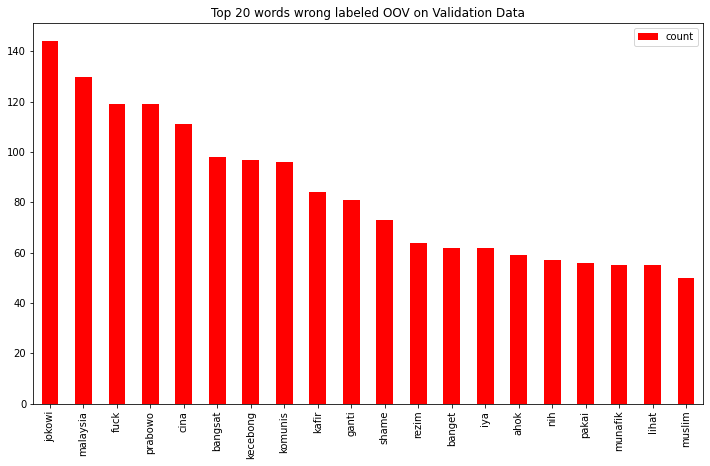

In [60]:
df_oov_test = pd.DataFrame(oov_test_count.items(),columns=["Tweet","count"])
df_oov_test.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

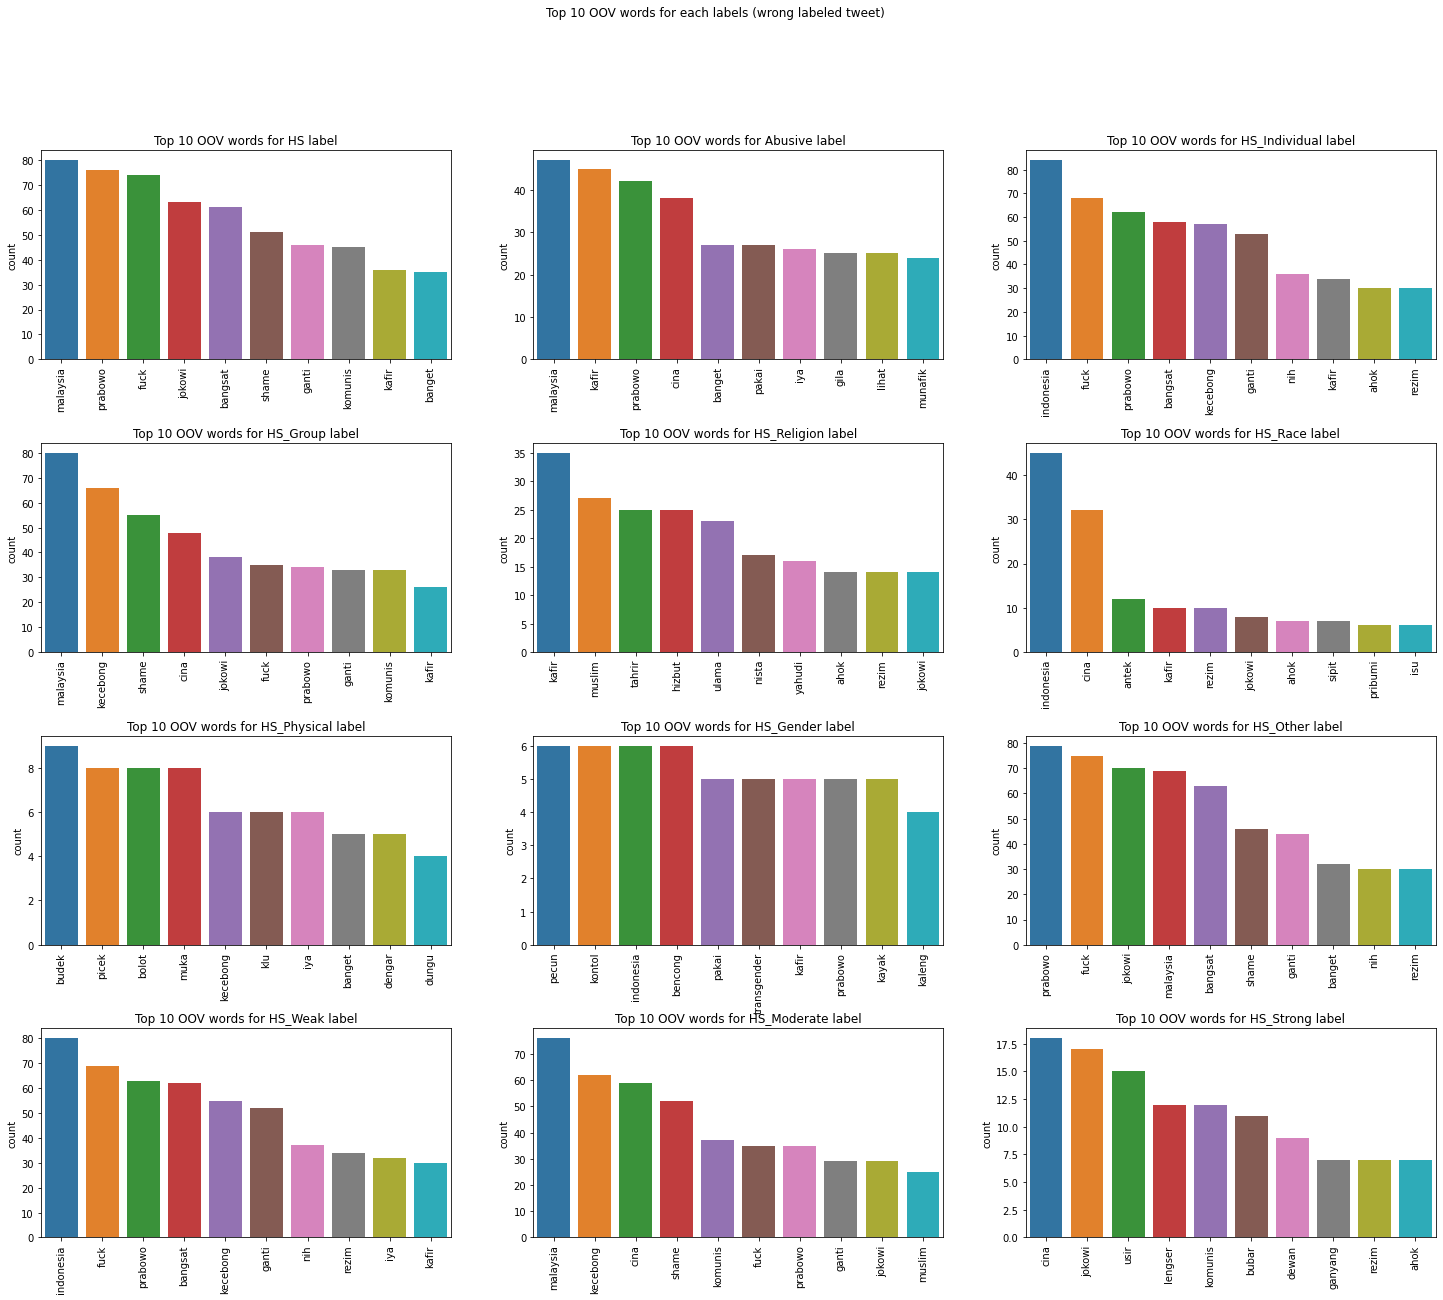

In [61]:
plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_test[join_data_test[target[i]]!=join_data_test[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vocab, wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

### Tweet Check

In [62]:
miss_exact_tweet_test['Tweet'].values.tolist()

["GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO YOU THINK YOU ARE? YOU'RE NOTHING!! TO ME! << REMEMBER THIS!!",
 "USER USER Karena partaimu pdip itu bajingan'",
 "USER Khan yg ngajarin si garong kafir'",
 "USER Anak pecun... ga jauh2 dr hobi zina.. haha'",
 'USER Udah siap di demo berjilid2 sama bani cingkrang ? Malaysia memberlakukan syariat Islam, tapi melegalkan perjudian dengan berbagai syarat dan ketentuan yg "strict".\'',
 "Hamdalah. Kelar juga ini fitur keparat.'",
 'Yue: i can excuse kiki and asheng becoming cabecabean but i drew a line in charlotte AND ronan having that sweet touch of a cabe',
 "USER USER USER USER USER USER iyain dah tante jablay wkwk'",
 "USER Kelemahan gerindra itu ada di orang ini,...Prabowo turun elektabilitasnya karena CONGOR fadlizon spt DURNO'",
 'indonesia: literally suffocating from the air pollution\n\nthe kampungan people watching over their trash burning:  pic.twitter.com/4ny5B7F2uX',
 '#MataNajwaDebatJakarta lucu banget jawaban ahok.. gak nyambun

In [63]:
miss_exact_tweet_test['Tweet_Parsed'].values.tolist()

['ganteng berengsek think nothing remember',
 'user user partai partai demokrasi indonesia juang bajing',
 'user ajar garong kafir',
 'user anak pecun hobi zina',
 'user demo jilid jilid ban cingkrang malaysia laku syariat islam legal judi syarat strict',
 'hamdalah selesai fitur keparat',
 'yue excuse kiki asing become cabe cabe draw line charlotte ronan sweet touch cabe',
 'user user user user user user iya tante jablay',
 'user lemah gerindra orang prabowo turun elektabilitasnya congor fadli zon durno',
 'indonesia literally suffocate air pollution kampung people tonton sampah burn',
 'mata najwa debat jakarta lucu banget ahok sambung kena sekak mat isu agama dasar cina tolol',
 'user astaga sewa pecun',
 'idiot makan upil',
 'habis pikir kunti masuk rumah berani bayang berani bayang end',
 'cheat menang distinguish loser shame malaysia sea game',
 'doe bio look fake liar liar nobody like liar proud stop lie',
 'educate self little say pikir like upin ipin film munafik well narrow m

In [64]:
miss_exact_tweet_test.iloc[:,2:-13].columns

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')

In [65]:
# real label
miss_exact_tweet_test.iloc[:,2:-13].values.tolist()

[[1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
 [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0,

In [0]:
miss_exact_tweet_test.to_csv("/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/bestresult_distilbert_full.csv",index=False,sep=";")